# Linear Regression

In this notebook, we show how to create, train and evaluate a linear regression model using Concrete-ML library, our open-source privacy-preserving machine learning framework based on fully homomorphic encryption (FHE). 

First, we generate a random clear data-set. Then, we compare 2 linear regression models :

- `sklearn_lr` : from Sklearn, which is trained, tested and evaluated on clear data.   
- `concrete_lr` : from Concrete-ML, which is trained on clear data. Then, quantized and compiled it in FHE. Finally, we test it on _encrypted data_.

This notebook aims to show how easy it is to use Concrete-ML and how FHE allows to secure the data during the inference phase.

Let's get started.

### Import libraries

We import the required packages.

In [1]:
import time

import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from concrete.ml.sklearn import LinearRegression as ConcreteLinearRegression

And some helpers for visualization.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

train_plot_config = {"c": "black", "marker": "D", "s": 15, "label": "Train data"}
test_plot_config = {"c": "red", "marker": "x", "s": 15, "label": "Test data"}


def get_sklearn_plot_config(r2_score=None):
    label = "scikit-learn"
    if r2_score is not None:
        label += f", {'$R^2$'}={r2_score:.4f}"
    return {"c": "blue", "linewidth": 2.5, "label": label}


def get_concrete_plot_config(r2_score=None):
    label = "Concrete-ML"
    if r2_score is not None:
        label += f", {'$R^2$'}={r2_score:.4f}"
    return {"c": "orange", "linewidth": 2.5, "label": label}

### Generate a data-set

In [3]:
# pylint: disable=unbalanced-tuple-unpacking
X, y = make_regression(
    n_samples=200, n_features=1, n_targets=1, bias=5.0, noise=30.0, random_state=42
)
# pylint: enable=unbalanced-tuple-unpacking

# We split the data-set into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# We sort the test set for a better visualization
sorted_indexes = np.argsort(np.squeeze(X_test))
X_test = X_test[sorted_indexes, :]
y_test = y_test[sorted_indexes]

We display the data-set to visualize the data distribution.

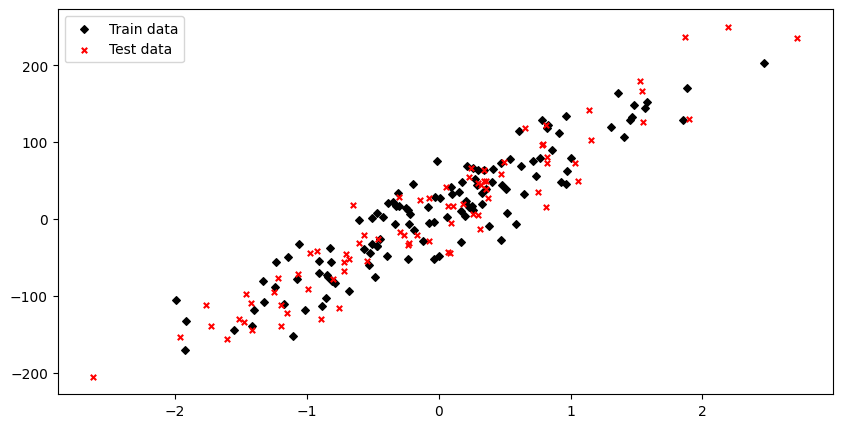

In [4]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(10, 5))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, **train_plot_config)
ax.scatter(X_test, y_test, **test_plot_config)
ax.legend()
display(fig)

### 1. LinearRegression model from Sklearn 

We train the scikit-learn LinearRegression model on clear data and then we test it.

In [5]:
sklearn_lr = SklearnLinearRegression()
sklearn_lr.fit(X_train, y_train)
y_pred = sklearn_lr.predict(X_test)

# Compute the R2 scores
sklearn_r2_score = r2_score(y_test, y_pred)

We can visualize our predictions to see how the scikit-learn model performs.

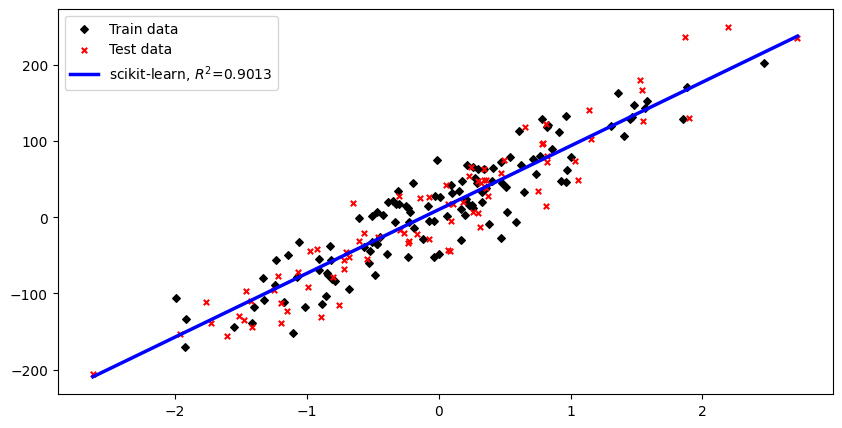

In [6]:
plt.ioff()
plt.clf()

fig, ax = plt.subplots(1, figsize=(10, 5))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, **train_plot_config)
ax.scatter(X_test, y_test, **test_plot_config)
ax.plot(X_test, y_pred, **get_sklearn_plot_config(sklearn_r2_score))
ax.legend()
display(fig)

### Prerequisites

Some prerequisites should be reviewed before deep diving !

Quantization is a technique that converts continuous data (floating point, e.g., in 32-bits) to discrete numbers
within a fixed range (e.g. integer in 8-bits). This means that some information is lost during the process. However, the larger is the integers' range, the smaller the error becomes, making it acceptable to some cases.

To learn more about quantization, please refer to this [page](https://docs.preprod.zama.ai/concrete-ml/main/advanced-topics/quantization.html).

Regarding FHE, the input data type must be represented exclusively as integers, making the use of quantization necessary. Therefore, a linear model trained on floats is quantized into an equivalent integer model using _Post-Training Quantization_. This operation can lead to a loss of accuracy compared to the standard floating point models working on clear data. 

In practice however, this loss is usually very limited with linear FHE models as they can consider very large integers, with up to 50 bits in some cases. This means these models can quantize their inputs and weights over large number of bits (e.g. 16) while still considering data-sets containing many features (e.g. 1000). We therefore often observe almost identical performance scores (e.g. R2 score) between float, quantized and FHE models.  

To learn more about the relation between the maximum bit-width reached within a model, the bits of quantization used and the data-set's number of features,  please refer to this [page](https://docs.preprod.zama.ai/concrete-ml/main/advanced-topics/pruning.html?highlight=formula#pruning-in-practice).

### 2. Linear Regression model with Concrete-ML

The typical development flow of a Concrete-ML model is the following:

- The model is trained on clear (plaintext) data as only FHE inference is currently supported

- The resulting trained model is quantized using a `n_bits` parameter set by the user, which can either be:

    1. a dictionary composed of `op_inputs` and `op_weights` keys. These parameters are given as 
    integers representing the number of bits over which the associated data should be quantized.

    2. an integer, representing the number of bits over which each input and weight should be quantized.
    Default is 8.

- The quantized model is compiled to a FHE equivalent following 3 steps:

    + create an executable operation graph

    + check that the op-graph is FHE compatible by checking the maximum bit-width needed to execute the model

    + determine cryptographic parameters that will help to generate the secret keys and evaluation keys. 
    If no parameters can be found, the compilation process can't be completed and an error is thrown. 
    The user then can either lower the value(s) chosen for `n_bits` or decrease the number of features 
    found in the data-set (using techniques such as [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html))
    and run the development flow once again.

- Inference can then be done on encrypted data

### 2.1 Quantized Linear Regression without FHE

In this example, we show you how to quantize a model with Concrete-ML, and how to train and test it on plaintext data.

In [7]:
# We quantize the inputs using 8-bits
concrete_lr = ConcreteLinearRegression(n_bits=8)

# We train the concrete linear regression model on clear data
concrete_lr.fit(X_train, y_train)

# We densify the space representation of the original X,
# to better visualize the resulting step function in the following figure
x_space = np.linspace(X_test.min(), X_test.max(), num=300)
x_space = x_space[:, np.newaxis]
y_pred_q_space = concrete_lr.predict(x_space)

# Now, we can test our Concrete-ML model on the clear test data
y_pred_q = concrete_lr.predict(X_test)

# Compute the R2 scores
quantized_r2_score = r2_score(y_test, y_pred_q)

Now, let's visualize our predictions.

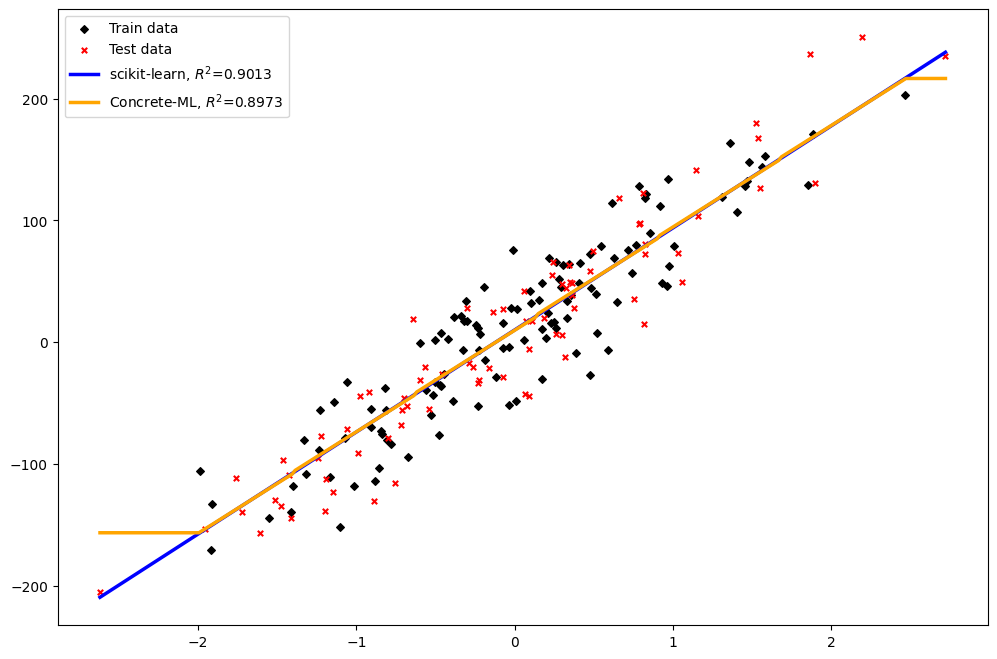

In [8]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, **train_plot_config)
ax.scatter(X_test, y_test, **test_plot_config)
ax.plot(X_test, y_pred, **get_sklearn_plot_config(sklearn_r2_score))
ax.plot(x_space, y_pred_q_space, **get_concrete_plot_config(quantized_r2_score))
ax.legend()
display(fig)

As you can see, the quantized model almost perfectly matches its float equivalent model inside the training domain.
There is however a very small decrease in the performance as the model poorly generalizes outside of it.

### 2.2 Quantized Linear Regression with FHE


To perform homomorphic inference, we take the above trained quantized model and we compile it to get a FHE model.
 
The compiler requires an exhaustive set of data to evaluate the maximum integer bit-width within the graph, which is needed during the FHE computations before running any predictions. 

The user can either provide the entire train data-set or a smaller but representative subset of it.

In [9]:
fhe_circuit = concrete_lr.compile(X_train)

#### Generate the key

The compiler returns a circuit, which can then be used for key generation and predictions. More precisely, it generates:
- a Secret Key, used for the encryption and decryption processes. This key should remain accessible only to the user.
- an Evaluation Key, used to evaluate the circuit on encrypted data. Anyone could access this key without breaching the model's security.

In [10]:
print(f"Generating a key for a {fhe_circuit.graph.maximum_integer_bit_width()}-bit circuit")

Generating a key for a 9-bit circuit


In [11]:
time_begin = time.time()
fhe_circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.4f} seconds")

Key generation time: 0.0002 seconds


Now let's predict using the FHE model on encrypted data.

In [12]:
# Now predict using the FHE-quantized model on the testing set
time_begin = time.time()
y_pred_fhe = concrete_lr.predict(X_test, execute_in_fhe=True)
print(f"Execution time: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample")

Execution time: 0.0004 seconds per sample


### Evaluate all the models

In the following, we use $R^2$-score metric to evaluate each model's performance.

In [13]:
# Measure the FHE R2 score
fhe_r2_score = r2_score(y_test, y_pred_fhe)

print("R^2 scores:")
print(f"scikit-learn (clear): {sklearn_r2_score:.4f}")
print(f"Concrete-ML (quantized): {quantized_r2_score:.4f}")
print(f"Concrete-ML (FHE): {fhe_r2_score:.4f}")

# Measure the error of the FHE quantized model with respect to the clear scikit-learn float model
concrete_score_difference = abs(fhe_r2_score - quantized_r2_score) * 100 / quantized_r2_score
print(
    "\nRelative difference between Concrete-ml (quantized clear) and Concrete-ml (FHE) scores:",
    f"{concrete_score_difference:.2f}%",
)


# Measure the error of the FHE quantized model with respect to the clear float model
score_difference = abs(fhe_r2_score - sklearn_r2_score) * 100 / sklearn_r2_score
print(
    "Relative difference between scikit-learn (clear) and Concrete-ml (FHE) scores:",
    f"{score_difference:.2f}%",
)

R^2 scores:
scikit-learn (clear): 0.9013
Concrete-ML (quantized): 0.8973
Concrete-ML (FHE): 0.8973

Relative difference between Concrete-ml (quantized clear) and Concrete-ml (FHE) scores: 0.00%
Relative difference between scikit-learn (clear) and Concrete-ml (FHE) scores: 0.45%


We can observe that scikit-learn and Concrete-ML models output very close $R^2$ scores. This demonstrate how the quantization process has a very limited impact on performances. 

### Plot the results of the Sklearn model and the FHE one

In [14]:
# For better visualization
y_pred_q_space = concrete_lr.predict(x_space)

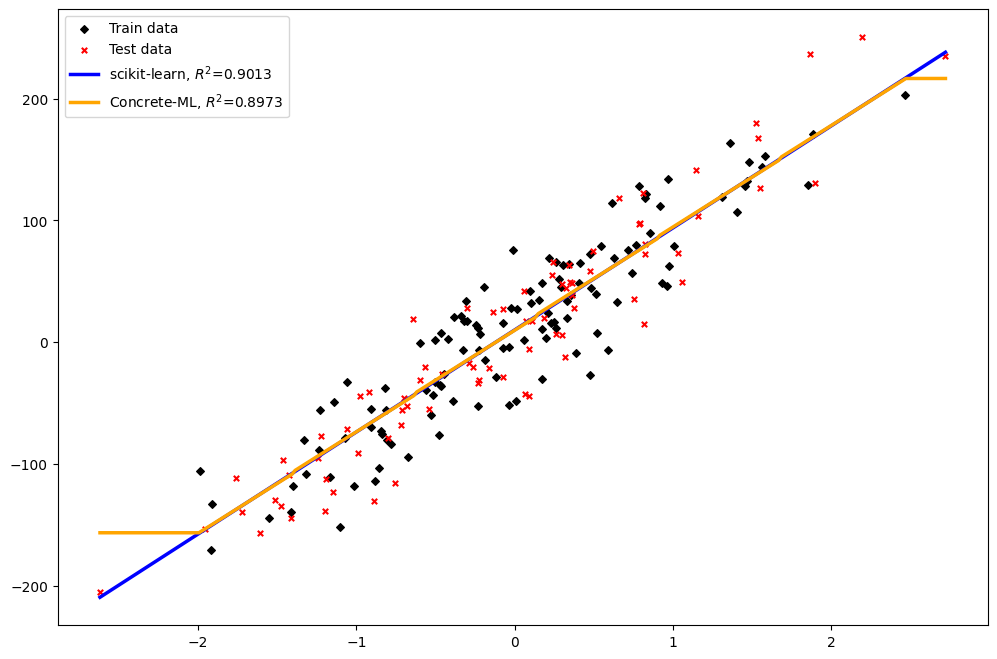

In [15]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, **train_plot_config)
ax.scatter(X_test, y_test, **test_plot_config)
ax.plot(X_test, y_pred, **get_sklearn_plot_config(sklearn_r2_score))
ax.plot(x_space, y_pred_q_space, **get_concrete_plot_config(fhe_r2_score))
ax.legend()

display(fig)

## Conclusion

In this tutorial, we have shown how easy it is to train and execute a linear regression model in FHE using Concrete-ML. 

We have also discussed the development flow of a FHE model: training, quantization, compilation and inference.

The slight decrease in prediction quality is due to the quantization of the model's weights and input data, which makes the model poorly generalize outside of its training domain. However, this decrease remains negligible as both floating point (scikit-learn) and FHE (Concrete-ML) models give almost identical R2 scores.
